## Finding nearest neighbors

Try implementing: https://stackoverflow.com/questions/10818546/finding-index-of-nearest-point-in-numpy-arrays-of-x-and-y-coordinates

In [2]:
#General libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

#Regular expression
import re

In [128]:
# Define functions to find N nearest games
#Using Euclidean distance in t-sne or multi-dimensional space

def calc_distance(target_coord, all_coord):
    '''Take 1 set of target coordinates and a matrix containing all coordinate sets. Calculate the distances of all coordinates
    to the target coordinate.
    
    Returns an array of distances.'''
    
    # Calculate distance
    summed_distance = np.square(all_coord-target_coord).sum(axis=1) #Euclidean distance formula
    distance = np.sqrt(summed_distance.astype(np.float64)) #Need to convert summed_distance to np.float64 for sqrt function to work

    return distance


def find_game_NN(game, game_coordinates,n=5):
    '''Take the target game name (string), the dataframe of coordinates (pandas dataframe), and number of games to return (int).
    Game_coordinates can be euclidean or t-sne or any other coordinates. First column must be game name. All other columns are 
    coordinates in multi-dimensional space.
    
    Returns a dataframe with n boardgame names and distances calculated CLOSEST to the target name'''
    
    # Get the coordinates of target game, converted to matrix
    target_coord = game_coordinates[game_coordinates['Game name'] == game].iloc[0,1:].as_matrix()
    
    # Convert the coordinate dataframe to matrix of coordinates
    all_coord = game_coordinates.iloc[:,1:].as_matrix()
    
    # Find nearest neighbors
    distances = calc_distance(target_coord, all_coord)
    closest_idx = np.argpartition(distances, n+1)[:n+1] #Get the n+1 closest games, which includes the target game itself
    
    # Get the game names and concatenate to the distances
    found = pd.concat([game_coordinates.iloc[closest_idx,0].reset_index(drop=True), #Need to reset index for concatenation
                       pd.DataFrame(distances[closest_idx],columns=['Similarity/Distance'])],
                     axis=1)
    
    # Remove the target game from the output
    found = found[found['Game name'] != game] 
    
    return found.sort_values(by=['Similarity/Distance']).reset_index(drop=True) #Sort output by calculated distance



In [140]:
# Define functions to find K furthest games
#Using Euclidean distance in t-sne space

def find_furthest_game(game, game_coordinates, k=5):
    
    # Get the coordinates of target game, converted to matrix
    target_coord = game_coordinates[game_coordinates['Game name'] == game].iloc[0,1:].as_matrix()
    
    # Convert the coordinate dataframe to matrix of coordinates
    all_coord = game_coordinates.iloc[:,1:].as_matrix()
    
    # Find nearest neighbors
    distances = calc_distance(target_coord, all_coord)
    closest_idx = np.argsort(distances)[-k:] #Get the k furthest games
    
    # Get the game names and concatenate to the distances
    found = pd.concat([game_coordinates.iloc[closest_idx,0].reset_index(drop=True), #Need to reset index for concatenation
                       pd.DataFrame(distances[closest_idx],columns=['Similarity/Distance'])],
                     axis=1)
    
    # Remove the target game from the output
    found = found[found['Game name'] != game] 
    
    return found.sort_values(by=['Similarity/Distance'], ascending=False).reset_index(drop=True) #Sort output by calculated distance

### Examples: T-SNE (Cat + Mech)

In [119]:
ga_tsne = pd.read_csv('bgg tsne coordinates 100Perplexity 2000Steps.csv')

#Drop the first column (just indices)
ga_tsne.drop('Unnamed: 0', inplace=True, axis=1)

ga_tsne[['Ax1','Ax2']] = ga_tsne[['Ax1','Ax2']].apply(pd.to_numeric)

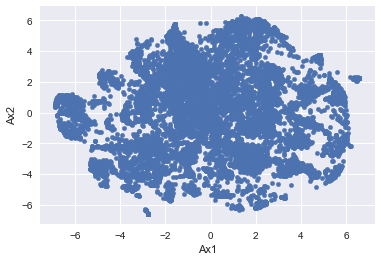

In [120]:
#Make the tsne plot again
ga_tsne.plot(x='Ax1',y='Ax2',kind='scatter')

In [129]:
find_game_NN('Monopoly', ga_tsne, 5)

,Game name,Similarity/Distance
0,Monopoly: X-Men,0.000838
1,Monopoly: Marvel Comics,0.001518
2,Monopoly: Electronic Banking,0.001806
3,Monopoly: Tropical Tycoon DVD Game,0.002035
4,Monopoly: Nintendo,0.004181


In [130]:
find_game_NN('Pandemic',ga_tsne,5)

,Game name,Similarity/Distance
0,Pandemic Iberia,0.028966
1,Pandemic Legacy: Season 1,0.082755
2,Pandemic: Reign of Cthulhu,0.092547
3,Dragon Keeper: The Dungeon,0.097617
4,Ticket to Ride: Europe,0.100043


As expected, Monopoly's closest games finds a bunch of other Monopoly games. Similarly, Pandemic also finds three of the other Pandemic games.

### Example: Full multi-dimensional space (Cat + Mech)

In [133]:
# Load game attributes csv
ga = pd.read_csv('bgg game attributes edited.csv')

# Remodel the csv
#Drop the first column (just indices)
ga.drop('Column1', inplace=True, axis=1)

#Rename headers with the actual headings (stored in first row)
ga.rename(columns=ga.iloc[0], inplace=True)
ga.drop(0, inplace=True, axis=0)
ga.reset_index(drop=True, inplace=True)


#Set up scaling; remove text
ga_to_pca = ga.drop(['Game name','Game rank','Game ID','total categories','total mechanics'], axis=1)

# Normalize the non-binary values: #players, playtime, weight
#Import sklearn standardscaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#Fit and Transform via standard scaler
scaler.fit(ga_to_pca[['#players','playtime','weight']])
scaled_ga = scaler.transform(ga_to_pca[['#players','playtime','weight']])

#Concatenate the normalized columns to the binary columns
scaled_ga = pd.concat([pd.DataFrame(scaled_ga, columns=['#players','playtime','weight']),ga_to_pca.drop(['#players','playtime','weight'],axis=1)],axis=1)
scaled_ga = scaled_ga.astype('float64')

# Add game names back on
full_ga = pd.concat([ga['Game name'], scaled_ga],axis=1)

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [134]:
find_game_NN('Monopoly',full_ga,5)

,Game name,Similarity/Distance
0,Superpoly,0.834827
1,Monopoly: The Portable Property Trading Game,1.012852
2,Monopoly: National Parks Edition,1.016252
3,Monopoly: 1935 Deluxe,1.047330
4,Monopoly: Canadian Edition,1.083097


In [135]:
find_game_NN('Pandemic',full_ga,5)

,Game name,Similarity/Distance
0,Pandemic Iberia,0.334459
1,Pandemic Legacy: Season 1,1.104349
2,Pandemic: Reign of Cthulhu,1.764757
3,Kings of Israel,2.000456
4,Dream Islands,2.295881


There are some slight differences, but it seems at least for Monopoly and Pandemic, we are getting similar outputs when using the t-sne coordinates and the full game attributes coordinates.

### Weird effect with furthest game

When using find_furthest_game, different games have similar returns. Seems like there are games that naturally are just very different compared to MOST games. Thus using find_furthest_game might not be very useful because of the existence of these games.

In [146]:
find_furthest_game('Pandemic',full_ga,10)

,Game name,Similarity/Distance
0,The Campaign for North Africa,96.790938
1,Start Player: A Kinda Collectible Card Game,59.319771
2,Scrimish Card Game,59.303208
3,"I Don't Know, What Do You Want To Play?",59.300717
4,Case Blue,36.486923
5,1914: Offensive à outrance,28.057514
6,Atlantic Wall: D-Day to Falaise,23.576599
7,The Hammer of Thor: The Game of Norse Mythology,21.617451
8,Empires in Arms,19.842704
9,Drang Nach Osten!,19.751249


In [148]:
find_furthest_game('Case Blue',full_ga,10)

,Game name,Similarity/Distance
0,Start Player: A Kinda Collectible Card Game,69.731627
1,"I Don't Know, What Do You Want To Play?",69.709194
2,Scrimish Card Game,69.623051
3,The Campaign for North Africa,60.494978
4,The Hammer of Thor: The Game of Norse Mythology,42.119313
5,Linkee,38.444128
6,Alchemidus,37.363232
7,Kaleidos Junior,37.224218
8,Wonky,37.135051
9,Start Player,37.133475


This effect doesn't seem to hold with the t-sne coordinates.

In [149]:
find_furthest_game('Pandemic',ga_tsne,10)

,Game name,Similarity/Distance
0,Linkee,8.661021
1,Alchemidus,8.658250
2,Act One,8.656587
3,Martian Dice,8.656459
4,Rolling Japan,8.656183
5,Rolling America,8.656146
6,Micro Robots,8.656085
7,Zombie Dice,8.656079
8,Streams,8.656070
9,Picture Pursuit,8.656070


In [152]:
find_furthest_game('Linkee', ga_tsne,10)

,Game name,Similarity/Distance
0,When Zombies Attack!,13.597963
1,Space Invaders Dice!,13.587986
2,Zombie Mania!,13.571454
3,Luchador! Mexican Wrestling Dice,13.565859
4,Yamslam,13.565623
5,Back to the Future: OUTATIME,13.563616
6,Raging Bulls,13.561810
7,"The Walking Dead ""Don't Look Back"" Dice Game",13.561499
8,Ninja Dice,13.559393
9,Bottom of the 9th,13.555704


In [150]:
find_furthest_game('Case Blue', ga_tsne, 10)

,Game name,Similarity/Distance
0,1812,12.306801
1,1831,12.301623
2,18C2C: Manifest Destiny,12.301355
3,18West,12.300204
4,18OE: On the Rails of the Orient Express,12.287770
5,18US,12.287461
6,18EU,12.285414
7,1817,12.284167
8,1886,12.282171
9,18Ireland,12.272036


In both ga_tsne and full_ga cases, games furthest from Pandemic don't necessarily lead back to Pandemic being furthest away. This is largely in part due to how points are distributed in the space (that games are not necessarily the furthest from each other).

Thus find_furthest_game definitely seems less useful, whereas finding the nearest neighbors still has value. Or rather, having low dissimilarity scores/close distances is a good indicator of similarity, but high dissimilarity scores/far distances are not really informative about HOW different games are.

## Comparing Mech+Cat vs Mech only vs Cat only

In [131]:
find_game_NN('Monopoly:  80th Anniversary Edition', ga_tsne, 10)

,Game name,Similarity/Distance
0,Anti-Monopoly,0.015104
1,Monopoly: The Walking Dead – Survival Edition,0.024964
2,Colosseum,0.025035
3,The Bottom Line,0.027640
4,La Ruta del Tesoro,0.048201
5,Capitaly,0.048976
6,Monopoly: 60th Anniversary Edition (1935-1995),0.051595
7,Caravans of Ahldarahd,0.052025
8,Oneupmanship: Mine's Bigger,0.052406
9,The American Dream Game,0.053000


Weirdly, Monopoly's 80th Anniversary only registers one other Monopoly game. Would normally expect monopoly games to cluster together... Perhaps this is the effect of categories?

In [154]:
# Get mech tsne
ga_tsne_mech = pd.read_csv('bgg mech-only tsne coordinates.csv')

#Drop the first column (just indices)
ga_tsne_mech.drop('Unnamed: 0', inplace=True, axis=1)

ga_tsne_mech[['Ax1','Ax2']] = ga_tsne_mech[['Ax1','Ax2']].apply(pd.to_numeric)

In [155]:
# Get tsne
ga_tsne_cat = pd.read_csv('bgg cat-only tsne coordinates.csv')

#Drop the first column (just indices)
ga_tsne_cat.drop('Unnamed: 0', inplace=True, axis=1)

ga_tsne_cat[['Ax1','Ax2']] = ga_tsne_cat[['Ax1','Ax2']].apply(pd.to_numeric)

In [156]:
find_game_NN('Monopoly:  80th Anniversary Edition', ga_tsne_mech, 10)

,Game name,Similarity/Distance
0,Monopoly: Las Vegas,0.002592
1,Monopoly: NHL,0.003620
2,Monopoly: Euro,0.004031
3,Monopoly: Star Wars Episode II,0.004194
4,Monopoly: Family Game Night Championship Edition,0.004204
5,Monopoly: Star Trek Continuum Edition,0.004765
6,Monopoly: The Lord of the Rings Trilogy Edition,0.005334
7,Eurobusiness,0.005432
8,Monopoly Millionaire,0.005871
9,Monopoly: NFL Official,0.005991


Looks like if we just look at mechanics, Monopoly 80th Anniversary does lie near other Monopolies!

In [157]:
find_game_NN('Monopoly:  80th Anniversary Edition', ga_tsne_cat, 10)

,Game name,Similarity/Distance
0,Die Erbraffer,0.006309
1,Die Schlangen von Delhi,0.010758
2,Wakanda,0.013090
3,Outside the Scope of BGG,0.034385
4,Bubblee Pop,0.050602
5,ERA,0.059762
6,Tjuv och polis,0.066886
7,Bomb Squad Academy,0.068053
8,GobbleStones,0.081803
9,Chronos Conquest,0.092635


Indeed, Monopoly 80th Anniversary is categorically similar to a bunch of games that aren't Monopoly games. So it looks like Categories count for quite a lot and can make games seem more DISSIMILAR even if they are mechanically similar.